### Description

In [1]:
### This code ingests a df of cleaned output and input variables and runs code to decide
### which calibration of Elastic Net vs. amended fused lasso works best.

### Imports

In [2]:
import pandas as pd

import numpy as np
from datetime import datetime
import xlsxwriter
import string
import os
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.neighbors import KernelDensity
import seaborn as sns
import cvxpy as cp
from scipy.optimize import minimize

In [3]:
from scipy.optimize import minimize

## Specify parameters [1]

In [63]:
window_range = [1,2,3,4,5,6]+list(7*np.array(range(1,25)))
shift_range = range(1,14)


### Specify what indicators to use
### These variables should be iterable based on either a shift or a rolling window.It may be iterable multiple times

    
alph_high_range = [0.6,0.7,0.8,0.9,0.95]
alph_low_range = [0.1,0.2,0.3,0.4,0.5]
x_variables = ['rolling_avg_pct_change','momentum','ema_diff','RSI']
y_variables = ['forward_opportunity_binary']
dep_var = ['forward_21_opportunity_pct_size']


file_path = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\cleaned_matrices\technical_indicator_clean.csv"
pricing_data_string = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\Raw data\EURUSD\2020-05-05_EURUSD_MIDPOINT_10 Y_1 day.csv"

## Specify data

In [6]:
data_in = pd.read_csv(filepath_or_buffer = file_path, index_col = 0)

In [7]:
pricing_data = pd.read_csv(filepath_or_buffer = pricing_data_string, index_col = 0)

In [8]:
failure_list = []
for item in list(data_in.columns):
    try:
        data_in[item] = data_in[item].astype("float64")
    except:
        failure_list.append(item)

In [9]:
if  len(failure_list) == 0:
    print("Cast succeeded")
else:
    print("failed items: " + str(len(failure_list)))

Cast succeeded


In [10]:
failure_list = []
for item in list(data_in.columns):
    try:
        data_in[item] = data_in[item].astype("float64")
    except:
        failure_list.append(item)

In [11]:
if  len(failure_list) == 0:
    print("Cast succeeded")
else:
    print("failed items: " + str(len(failure_list)))

Cast succeeded


## Clean pricing data

In [12]:
data_columns = list(pricing_data.columns)
pricing_data_copy = pricing_data.copy(deep = True)
pricing_data_copy = pricing_data_copy.rename( columns = {
    
    'date': 'date',
    'close':'price',
    #'Ticker':'ticker'
    
})
pricing_data_copy['ticker'] = "EURUSD"
## Cast all relevant objects to floats

float_list = ['price','open']

for item in float_list:
    pricing_data_copy[item] = pricing_data_copy[item].astype('float64')
    ## Cast all relevant objects to dates

float_list = ['date']
for item in float_list:
    pricing_data_copy[item] = pd.to_datetime(pricing_data_copy[item])

In [13]:
pricing_data.head(2)

,date,open,high,low,close,volume,average,barCount
0,2010-05-10,1.290875,1.309450,1.27595,1.2787,-1,-1.0,-1
1,2010-05-11,1.278325,1.280325,1.26565,1.2662,-1,-1.0,-1


### Calculate properties of FD

In [14]:

first_difference = pricing_data_copy['price'] - pricing_data_copy['price'].shift(1)

In [15]:
first_difference = first_difference.dropna()

In [16]:
first_difference.reset_index(inplace = True, drop = True)

In [17]:
## 1. Calculate mean and variance

In [18]:
mean = first_difference.mean()
std = first_difference.std()
skew = first_difference.skew()
kurtosis = first_difference.kurtosis()

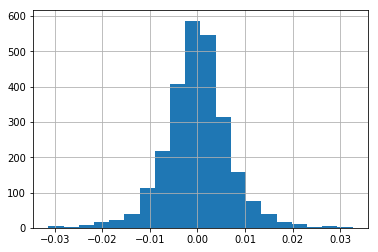

In [19]:
first_difference.hist(bins = 20)

In [20]:
kurtosis

2.0037033577421424

In [21]:

# seed the random number generator

stat, p = shapiro(first_difference)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)


In [22]:
### Test skewness and kurtosis
stats.jarque_bera(first_difference)


(432.20546343738715, 0.0)

In [23]:
### Instead let's try KDE

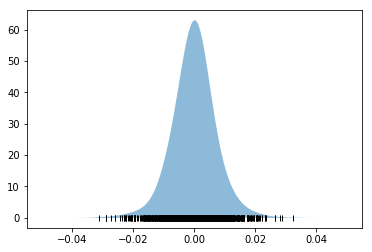

In [24]:
x_d = np.linspace(-0.05, 0.05, 1000)
x = np.array(first_difference)
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.003, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)


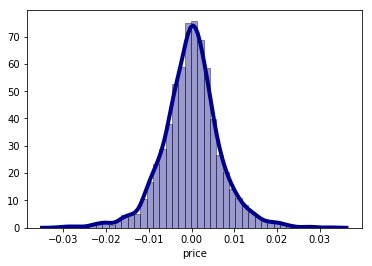

In [25]:
#Visualisation:
sns.distplot(first_difference, hist=True, kde=True, 
             bins=int(round((len(first_difference)/60))), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

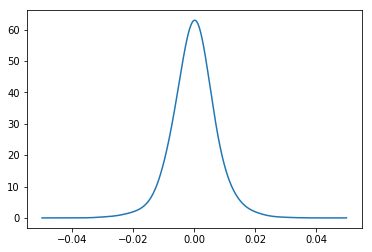

In [26]:

x = np.array(first_difference)
xs = np.linspace(-0.05,0.05,1000)
# expects n x p matrix with p features
x.shape = (len(x), 1)
xs.shape = (len(xs), 1)
#### Question@ is this the correct KDE to use? Probably can be refined and generalised....
kde = KernelDensity(bandwidth=0.003).fit(x)
dens = np.exp(kde.score_samples(xs))
plt.plot(xs, dens)
pass

In [27]:
probs = dens / sum(dens)
xs_comma = np.reshape(xs,newshape = (len(xs),))

In [28]:
mc = np.random.choice(xs_comma, size=10000, replace=True, p=probs)

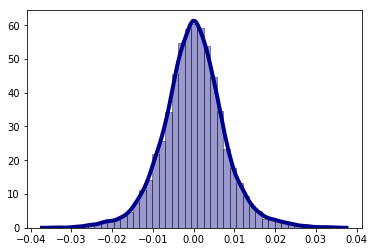

In [29]:
#Visualisation:
sns.distplot(mc, hist=True, kde=True, 
             bins=int(round((len(first_difference)/60))), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [30]:
new_df = pd.DataFrame(mc)
###########

In [31]:
new_df.mean()#####

0   -0.000013
dtype: float64

In [32]:
new_df.iloc[0] = 0#
new_df['price'] = 0##
new_df['price'].iloc[0] = 1#
new_df['price_calc'] = new_df['price'].cumsum() + new_df[0].cumsum()#

C:\Users\hugo.lu\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


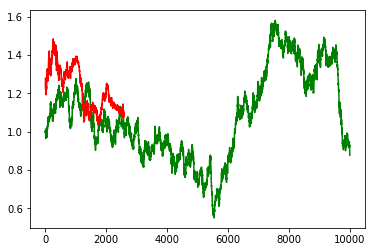

In [33]:
plt.plot(new_df['price_calc'],c="g")
plt.plot(pricing_data_copy['price'],c="r")

### Calculate indicators

In [64]:
## Form of function = "calc_"+ indicator name in x / y variables.
def self_reference(f):
    f.__defaults__ = f.__defaults__[:-1] + (f,)
    return f

@self_reference
def calc_momentum(df,price,window,self=None):
    df['last_%s_momentum' % window] = (df[price] / df[price].shift(window))-1
    string = 'last_%s_momentum' % window
    return df,string

@self_reference
def calc_rolling_avg_pct_change(df,price,window,shift,self=None):
    string = "rolling_"+str(window)+"_avg_"+str(shift)+"_period_pct_change"
    df[string] = df[price].rolling(window).mean()
    df[string] = (df[string]/df[string].shift(shift))-1
    
    return df,string

@self_reference
def calc_rolling_avg(df,price,window,self=None):
    df['rolling_%s_avg_price' % window] = df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price' % window
    return df,string
 
@self_reference    
def calc_rolling_avg_price_dif(df,price,window,self=None):
    df['rolling_%s_avg_price_dif' % window] = df[price] - df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price_dif' % window
    return df,string

@self_reference
def calc_RSI(df,price,window,self=None):
    window = max(window,14)
    random = df.copy(deep = True)
    random['status'] = random[price] - random[price].shift(1)
    random['status'] = random['status'].apply(lambda x: "Up" if x > 0 else "Down")
    random['average_for_up'] = random['status'].apply(lambda x: 1 if x == "Up" else 0)
    random['average_for_down'] = random['status'].apply(lambda x: 0 if x == "Up" else 1)
    random['average_price_up'] = (random['price']-random['price'].shift(1)) * random['average_for_up']
    random['average_price_down'] = (random['price']-random['price'].shift(1))* random['average_for_down']*-1
    random['average_price_up'] = random['average_price_up'].apply(lambda x: None if x ==  0 else x )
    random['average_price_down'] = random['average_price_down'].apply(lambda x: None if x == 0 else x )
    random['last_%s_RSI' % window] = random['average_price_up'].rolling(window, min_periods =1).sum() / random['average_price_down'].rolling(window, min_periods =1).sum()
    df['last_%s_RSI' % window] = 1 - 1/(1+random['last_%s_RSI' % window])
    for item in range(0,window): ## Formula above will not give NANs for the first (window-1) terms as min_periods = 1.
        df.at[item,'last_%s_RSI' % window] = None
    output_string = "last_" + str(window)+"_RSI"

    return df,output_string
    

@self_reference
def calc_forward_opportunity(df,price,window,self=None):
    df['forward_%s_opportunity' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity' % window] = df['forward_%s_opportunity' % window].shift(-window) - df[price]
    string = 'forward_%s_opportunity' % window
    return df,string 

@self_reference
def calc_forward_opportunity_pct_sign(df,price,window,self=None):
    df['forward_%s_opportunity_pct_sign' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity_pct_sign' % window] = (df['forward_%s_opportunity_pct_sign' % window].shift(-window) - df[price])/df[price]
    df['forward_%s_opportunity_pct_sign' % window] = df['forward_%s_opportunity_pct_sign' % window].apply(lambda x: 0 if x<0 else 1)
    string = 'forward_%s_opportunity_pct_sign' % window
    return df,string 

@self_reference
def calc_forward_opportunity_pct_size(df,price,window,self=None):
    df['forward_%s_opportunity_pct_size' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity_pct_size' % window] = (df['forward_%s_opportunity_pct_size' % window].shift(-window) - df[price])/df[price]
    df['forward_%s_opportunity_pct_size' % window] = df['forward_%s_opportunity_pct_size' % window].apply(lambda x: -x if x<0 else x)
    string = 'forward_%s_opportunity_pct_size' % window
    return df,string 


@self_reference
def calc_forward_opportunity_binary(df,price,window,self=None):
    rider = df.copy(deep = True)
    string = "calc_forward_%s_opportunity_binary" % window
    
    rider['change'] = (rider[price]/rider[price].shift(1))-1 ## this will typically be stationary
    rider['mean'] = rider['change'].rolling(250).mean() # a list
    rider['std'] = rider['change'].rolling(250).std() # a list
    rider['standard'] = (rider['change'] - rider['mean'])/rider['std']
    #rider['standard'] = rider['standard'].apply(lambda x: -x if x <0 else x)
    rider['standard'] = rider['standard'].apply(lambda x: 1 if x >= 1.5 else 0)
    df[string] = rider['standard']
    return df,string

### specify function list; must be ordered:
@self_reference
def calc_ema(df,price,alph,self = None):
    df['last_%s_EMA' % window ] = df[price].ewm(alpha=alph).mean()
    string = 'last_%s_EMA' % window 
    return df,string

@self_reference
def calc_ema_cross(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    rider['dif'] = rider['dif'].apply(lambda x: 1 if x>0 else 0)
    rider['dif_lag'] = rider['dif'].shift(1)
    rider['dif_lag'] = rider['dif_lag'].apply(lambda x: 1 if x>0 else 0)
    rider['signal'] = rider['dif'] - rider['dif_lag']
    
    
    string = str(alph_high) + "_high_" + str(alph_low) + "_low_ema_cross"
    df[string] = rider['signal']
    return df,string

@self_reference
def calc_ema_diff(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    #print("xx")
    
    string = str(alph_high) + "_high_" + str(alph_low) + "_low_ema_dif"
    df[string] = rider['dif']
    return df,string


calc_momentum.type = "window"
calc_rolling_avg_pct_change.type = "window_shift"
calc_rolling_avg.type = "window"
calc_rolling_avg_price_dif.type = "window"
calc_RSI.type="window"
calc_forward_opportunity.type = "window"
calc_ema.type = "window"
calc_ema_cross.type = "alpha"
calc_ema_diff.type = "alpha"
calc_forward_opportunity_pct_size.type = "window"
calc_forward_opportunity_pct_sign.type = "window"
calc_forward_opportunity_binary.type = "window"

In [65]:
### Specify what indicators to use

all_variables = x_variables + y_variables
x_dic = {}
for item in x_variables:
    x_dic[item] = eval("calc_"+str(item))
    
y_dic = {}
for item in y_variables:
    y_dic[item] = eval("calc_"+str(item))

In [66]:
for a,b in y_dic.items():
    print(a)
    print(b)
for a,b in x_dic.items():
    print(a)
    print(b)

forward_opportunity_binary
<function calc_forward_opportunity_binary at 0x00000280AC0DB1E0>
rolling_avg_pct_change
<function calc_rolling_avg_pct_change at 0x00000280AC076D90>
momentum
<function calc_momentum at 0x00000280AC060D90>
ema_diff
<function calc_ema_diff at 0x00000280AC0DB378>
RSI
<function calc_RSI at 0x00000280AC076F28>


In [67]:
def calc_indicators(new_df,x_dic,y_dic,window_range,shift_range,alph_high_range,alph_low_range):
    
    x_variables_actual = []
    y_variables_actual = []
    print("Calculating x variables")
    for key,value in x_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            for item in window_range:

                [new_df,b] = value(new_df,'price',item)
                x_variables_actual.append(b)
        elif value.type == "window_shift":
            for item in window_range:
                for jtem in shift_range:
                    [new_df,b] = value(new_df,'price',item,jtem)
                    x_variables_actual.append(b)
        elif value.type == "alpha":
                for a in alph_high_range:
                    for c in alph_low_range:
                        [new_df,b] = value(new_df,'price',a,c)
                        x_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break

    print("Calculating y variables")
    for key,value in y_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            for item in window_range:

                [new_df,b] = value(new_df,'price',item)
                y_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                for item in window_range:
                    [new_df,b] = value(new_df,'price',item,jtem)
                    y_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break
    return new_df,x_variables_actual,y_variables_actual

In [68]:
def normalise_data(df,var_list):
    rider = df.copy(deep = True)
    data_mean = list(rider.mean())
    data_std = list(rider.std())
    rider = (rider - data_mean)/data_std
    rider = rider[var_list]
    df.loc[:,var_list] = rider.loc[:,var_list]
    return df

In [69]:
def delete_non_stationary_variables(df,x_variables_actual,y_variables_actual):
    stationary_vars = []
    
    for item in list(df.columns):
        #print(item)
        if item == 'price':
            print("Skip")
        else:
            X = df[item].dropna()
            result = adfuller(X)
            try:
                #print('ADF Statistic: %f' % result[0])
                #print('p-value: %f' % result[1])
                #print('Critical Values:')
                #for key, value in result[4].items():
                #    print('\t%s: %.3f' % (key, value))
                if result[0] < -3.434:
                    #print("Stationary for: " + str(item))
                    stationary_vars.append(item)
                else:
                    #print("Non stationary for: " + str(item))
                    try:
                        x_variables_actual.remove(item)
                    except:
                        y_variables_actual.remove(item)
            except:
                print(item)
    return df[stationary_vars],x_variables_actual,y_variables_actual

In [70]:
### Lasso

def loss_fn_lasso(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer_lasso(beta):
    return cp.norm1(beta)

def objective_fn_lasso(X, Y, beta, lambd):
    return loss_fn_lasso(X, Y, beta) + lambd * regularizer_lasso(beta)

def mse_lasso(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_lasso(X, Y, beta).value

## Ridge

def loss_fn_ridge(X, Y, beta):
    return cp.pnorm(X @ beta - Y, p=2)**2

def regularizer_ridge(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn_ridge(X, Y, beta, lambd):
    return loss_fn_ridge(X, Y, beta) + lambd * regularizer_ridge(beta)

def mse_ridge(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_ridge(X, Y, beta).value


## Elastic net

def loss_fn_elastic_net(X, Y, beta):
    return cp.pnorm(Y - X @ beta , p=2)**2

def regularizer_elastic_net(beta,lambd,lambd2):
    return (lambd2)*cp.pnorm(beta, p=2)**2 + (lambd)*cp.norm1(beta) 


def objective_fn_elastic_net(X, Y, beta, lambd,lambd2):
    return loss_fn_elastic_net(X, Y, beta) + regularizer_elastic_net(beta,lambd,lambd2)

def mse_elastic_net(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_elastic_net(X, Y, beta).value





In [71]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()


In [72]:
def conduct_lasso(data_copy,x_variables_actual,dep_var):
    x_variables_actual = list(set(x_variables_actual))
    
    regression_data = data_copy.copy(deep = True)
    regression_data = regression_data[x_variables_actual+dep_var]
    regression_data = regression_data.dropna()
    regression_data = (regression_data-regression_data.mean())/regression_data.std()

    m = len(regression_data)
    n = len(x_variables_actual)
    alpha = 0 ##Nests Lasso
    X = np.array(regression_data[x_variables_actual])
    if dep_var_type == "sign":
        Y = np.array(regression_data[dep_var].iloc[:,0].apply(lambda x: 1 if x > 0 else 0))
    else:    
        Y = np.array(regression_data[dep_var].iloc[:,0].apply(lambda x: -x if x<0 else x))
        Y = (Y - Y.mean())/Y.std()
    X_train = X[:int(m/2),:]
    Y_train = Y[:int(m/2)]
    X_test = X[int(m/2):,:]
    Y_test = Y[int(m/2):]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)
    lambd2 = cp.Parameter(nonneg=True)
    print("a")
    problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
    print("b")
    lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
    ## alpha = l2/(l1+l2)
    ## so l2 = l1*alpha/(1-alpha)
    lambd2_values = lambd_values*(alpha/(1-alpha))

    train_errors = []
    test_errors = []
    beta_values = []
    counter = 0
    print("c")
    for count,v in enumerate(lambd_values):
        lambd.value = v
        lambd2.value = lambd2_values[count]
        print("Values remaining: " +str(len(lambd_values)-count))
        problem.solve()
        test_error = mse_elastic_net(X_test, Y_test, beta)
        train_errors.append(mse_elastic_net(X_train, Y_train, beta))
        test_errors.append(test_error)
        beta_values.append(beta.value)
        


    opt_lambda = lambd_values[test_errors.index(min(test_errors))]
    opt_beta = beta_values[test_errors.index(min(test_errors))]
    y_pred = X_test@opt_beta
    avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
    pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
    r_squared = 1- (pred_ss/avg_ss)
    plot_train_test_errors(train_errors, test_errors, lambd_values)
    plot_regularization_path(lambd_values, beta_values)
    return r_squared,opt_lambda,opt_beta

In [73]:


def perform_mc_kde(x_values,probs,size,iterations):
    output_params = pd.DataFrame(index= range(0,iterations))
    output_values = pd.DataFrame()
    output_params['mean'] = None
    output_params['std'] = None
    output_params['skew'] = None
    output_params['kurtosis'] = None

    for i in range(0,iterations):
        mc = np.random.choice(x_values, size=size, replace=True, p=probs)
        new_df = pd.DataFrame(mc)
        ## Calculate params
        mean = new_df[0].mean()
        std = new_df[0].std()
        skew = new_df[0].skew()
        kurtosis = new_df[0].kurtosis()
        output_params.at[i,'mean'] = mean
        output_params.at[i,'std'] = std
        output_params.at[i,'skew'] = skew
        output_params.at[i,'kurtosis'] = kurtosis
        ## Calculate values
        new_df.iloc[0] = 0
        new_df['price'] = 0
        new_df['price'].iloc[0] = 1
        new_df['price_calc'] = new_df['price'].cumsum() + new_df[0].cumsum()
        output_values['price'] = new_df['price_calc']
        print("Completed simulation: " + str(i))
    
    return output_params,output_values

In [329]:
[properties,data]=perform_mc_kde(xs_comma,probs,10000,1)

Completed simulation: 0


C:\Users\hugo.lu\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [330]:
data_copy = data.copy(deep = True)

In [331]:
[out,x_var_list,y_var_list] = calc_indicators(data_copy
                                              ,x_dic,y_dic,window_range,shift_range,alph_high_range,alph_low_range)

Calculating x variables
Calculating y variables


In [332]:
## Use this to decide whether or not the KDE has yielded good results. To be honest, the kurtosis and skew differences
## do not look great. Let's press on in any case.

In [333]:
out = out[list(set(x_var_list)) + y_var_list]

In [334]:
[out,x_var_list,y_var_list] = delete_non_stationary_variables(out,x_var_list,y_var_list)

In [335]:
## Perform feature selection
def calc_covariance_matrix(df,x_var_list):
    df = df[x_var_list]
    df = df.dropna()
    df.reset_index(inplace = True, drop = True)
    
    
    df = df - df.mean()
    df = np.array(df)
    cov = df.T.dot(df)
    return cov
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

def perform_feature_selection(df): ## performs feature selection on a set of variables. Cannot contain NaNs
    if df != df.dropna():
        return "Not correctly specified"
    else:
        return
        

In [336]:
covariance = calc_covariance_matrix(out,x_var_list)

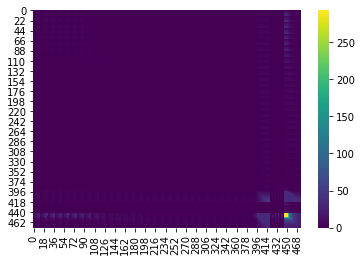

In [337]:
sns.heatmap(pd.DataFrame(covariance), cmap = "viridis")

In [338]:
correlation = cov2corr(covariance)

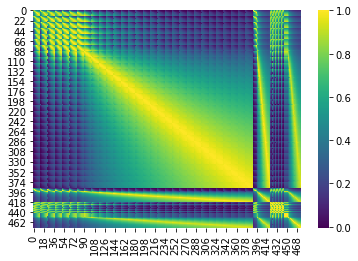

In [339]:
sns.heatmap(pd.DataFrame(correlation), cmap = "viridis")

## PCA

In [340]:
out_dna = out.dropna()
out_demean = out_dna - out_dna.mean()

In [341]:
x_vars = out_demean[list(set(x_var_list))]

In [342]:
x_vars.reset_index(drop = True, inplace = True)
#clean data

In [343]:
#calculate covariance matrix and get eigenvalues for pca
n= len(x_vars)
cx = np.array(x_vars.T)@(np.array(x_vars))/n
eVec=np.linalg.eigh(cx)
pca  = x_vars@eVec[1]

In [344]:
#total variance before pca
total_variance = np.trace(cx)

In [345]:
len(eVec[1])

468

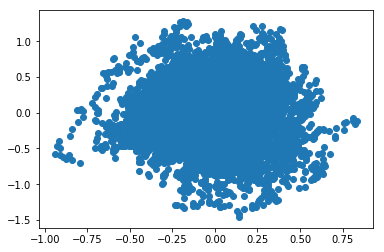

In [346]:
# Look at variance along first two pca
plt.scatter(pca.iloc[:,len(eVec[1])-2],pca.iloc[:,len(eVec[1])-1])

In [347]:
#See how many PC necessary to retain variance
for item in range(1,10):
    n = len(list(pca.columns))
    rider = pca.iloc[:,n-item:n]
    rider_cov = np.array(rider).T@np.array(rider)/len(rider)
    rider_var = np.trace(rider_cov)
    print("The variance % retained for PCA " + str(item) + " is " + str (rider_var/total_variance))

The variance % retained for PCA 1 is 0.6087397630468748
The variance % retained for PCA 2 is 0.7922751235698494
The variance % retained for PCA 3 is 0.8587864873977396
The variance % retained for PCA 4 is 0.890227338450893
The variance % retained for PCA 5 is 0.9089461933296336
The variance % retained for PCA 6 is 0.9232171371655463
The variance % retained for PCA 7 is 0.9356791912512629
The variance % retained for PCA 8 is 0.9463876464765159
The variance % retained for PCA 9 is 0.9543262934549235


In [349]:
len(pca)

9820

In [350]:
independent_vars = pca.iloc[:,n-9:n]

In [351]:
dependent_vars = (out_demean['calc_forward_3_opportunity_binary'])

In [352]:
dependent_vars = dependent_vars.round().apply(lambda x: 0 if x<1 else 1 )

### Test bagging classifier on principle components

In [372]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 
import pandas as pd 
  
# load the data 

X = np.array(independent_vars)
Y = np.array(dependent_vars)
#Y = np.reshape(Y,newshape = (len(Y),1))
  
seed = 8
kfold = model_selection.KFold(n_splits = 3, 
                       random_state = seed) 
  
# initialize the base classifier 
base_cls = DecisionTreeClassifier(min_samples_split = 10) 
  
# no. of base classifier 
num_trees = 500
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed,
                         max_samples = 6000,
                         bootstrap = True)
fit = model.fit(X,Y)
  
results = model_selection.cross_val_score(model, X, Y, cv = kfold) 
print("accuracy :") 
print(results.mean()) 

accuracy :
0.910087675503274


In [373]:
predictions = ((fit.predict(X)))

In [374]:
sum(predictions)

85

In [375]:
output = pd.DataFrame()
output['y_hat'] = predictions
output['y'] = Y
output['true_positives'] = None
output.at[(output['y'] ==1) & (output['y_hat']==1),'true_positives'] = 1

In [376]:
output.sum()

y_hat              85.0
y                 588.0
true_positives     85.0
dtype: float64

In [377]:
output.sum()
print("the true positive rate is:"+str(output['true_positives'].sum()/output['y_hat'].sum()))

the true positive rate is:1.0
